# Explortations in Dimmensionality Reduction and Collation for Signature Images:

The broader project of this repository is to create an embedding model that maps images of signatures to a vector space. To which the similarity of signatures are checked with cosine simialrity (or another similarity/distance formula).

I want to package the model that results into a pipeline where I can take a photo of two signatures with a scanner app on my phone and feed them into that pipeline directly. Since the model uses images, it will use convolutional layers. Which means the images must all be the same tensor size. 

What I aim to do in this notebook is to explore different sizes of tensors as candidates for how large the image data should be. This will adress data collation issues as well as offers an opportunity to explore how large, in terms of data size, each tensor should be. My intuition tells me that I can reduce the dimmensionality of the image tensors with max pooling without risking much performance up to the point where its too blurry to interpret as a human. This will need to be tested though.

### Result: 3 or 2 poolings appears to be a good option

## Loading in Signature Images
The images I am loafing in are from a forged vs real signature dataset I found on kaggle. 

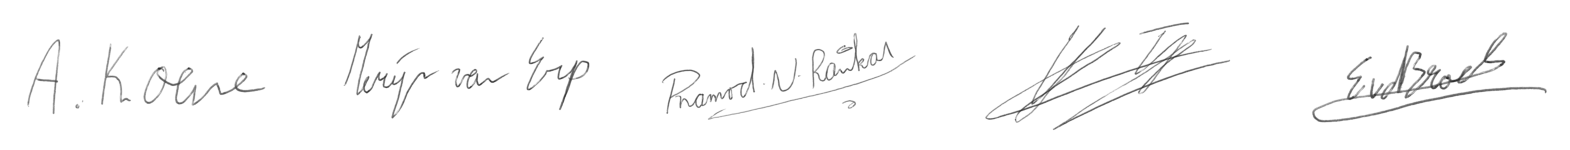

In [22]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_dir = r'C:\Users\hunte\OneDrive\Documents\Coding Projects\Signature-Similarity-Checker\data\handwritten-signatures\sample_Signature\sample_Signature\forged'

# Get all file names in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.PNG')]

# Load images into a list using PIL
images = [Image.open(os.path.join(image_dir, img_file)) for img_file in image_files]

# Display the first few images using matplotlib
plt.figure(figsize=(20, 4))
for i, img in enumerate(images[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()



## Convert to Tensor
Below I am applying the ToTensor() transform to each of the PIL images in the list comprehension.

In [24]:
import torch, torchvision
import torchvision.transforms as transforms

# Define a transform to convert the PIL images to PyTorch tensors
transform = transforms.ToTensor()

# Apply the transform to the images and convert them to PyTorch tensors
tensor_images = [transform(img) for img in images]

below I've printed the tensor shapes of the first 10 images. They are fairly large images and are not dimmensionally uniform. 

In [26]:
for i in range(10):
    print(tensor_images[i].shape)

torch.Size([1, 530, 1354])
torch.Size([1, 730, 1829])
torch.Size([1, 834, 2110])
torch.Size([1, 855, 1756])
torch.Size([1, 559, 1213])
torch.Size([1, 736, 933])
torch.Size([1, 423, 1304])
torch.Size([1, 599, 1675])
torch.Size([1, 826, 2073])
torch.Size([1, 653, 1545])


## Max Pooling for Dimensionality Reduction
Below I am going to experiment with how many times I can apply max pooling 2d to the images before they are not human readable. 

I've create five lists to hold maxpooling outputs after each time pooling is applied. We'll test 5 applications for human readability.

In [32]:
import torch.nn as nn
import torch.nn.functional as F

# get first 5 images
tensor_images = tensor_images[:5]

# initialize empty lists to hold maxpooling outputs
pooling_once, pooling_twice, pooling_thrice, pooling_fourth, pooling_fifth = [], [], [], [], []

# define a maxpooling layer with size 2 and stride 2
maxpooling = nn.MaxPool2d(2, stride=2)

# apply the maxpooling layer to the images
for img in tensor_images:
    pooling_once.append(maxpooling(img[None, :, :]))
    pooling_twice.append(maxpooling(pooling_once[-1]))
    pooling_thrice.append(maxpooling(pooling_twice[-1]))
    pooling_fourth.append(maxpooling(pooling_thrice[-1]))
    pooling_fifth.append(maxpooling(pooling_fourth[-1]))

print('Original image size: ', tensor_images[0].shape)
print('After 1st maxpooling: ', pooling_once[0].shape)
print('After 2nd maxpooling: ', pooling_twice[0].shape)
print('After 3rd maxpooling: ', pooling_thrice[0].shape)
print('After 4th maxpooling: ', pooling_fourth[0].shape)
print('After 5th maxpooling: ', pooling_fifth[0].shape)



Original image size:  torch.Size([1, 530, 1354])
After 1st maxpooling:  torch.Size([1, 1, 265, 677])
After 2nd maxpooling:  torch.Size([1, 1, 132, 338])
After 3rd maxpooling:  torch.Size([1, 1, 66, 169])
After 4th maxpooling:  torch.Size([1, 1, 33, 84])
After 5th maxpooling:  torch.Size([1, 1, 16, 42])


Below I am plotting each of the stages of max pooling against each other.

Text(0.5, 0.98, 'Maxpooling results')

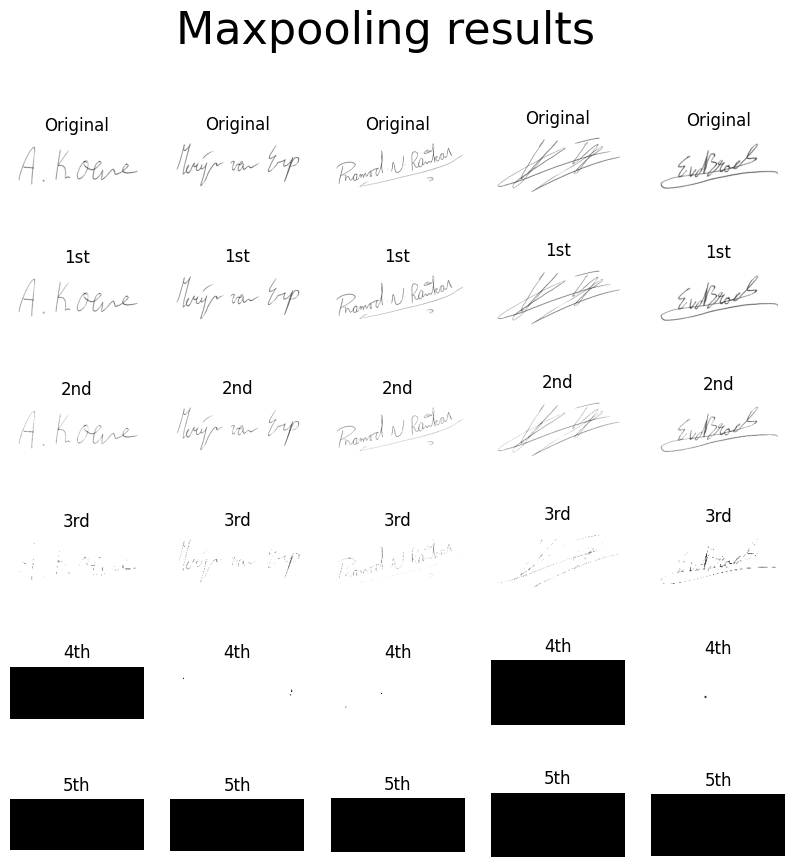

In [37]:
# plot in a 6x5 grid the results of the 5 maxpooling operations, including the original images and titles
fig = plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(6, 5, i+1)
    plt.imshow(tensor_images[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    plt.subplot(6, 5, i+6)
    plt.imshow(pooling_once[i].squeeze(), cmap='gray')
    plt.title('1st')
    plt.axis('off')
    plt.subplot(6, 5, i+11)
    plt.imshow(pooling_twice[i].squeeze(), cmap='gray')
    plt.title('2nd')
    plt.axis('off')
    plt.subplot(6, 5, i+16)
    plt.imshow(pooling_thrice[i].squeeze(), cmap='gray')
    plt.title('3rd')
    plt.axis('off')
    plt.subplot(6, 5, i+21)
    plt.imshow(pooling_fourth[i].squeeze(), cmap='gray')
    plt.title('4th')
    plt.axis('off')
    plt.subplot(6, 5, i+26)
    plt.imshow(pooling_fifth[i].squeeze(), cmap='gray')
    plt.title('5th')
    plt.axis('off')

#add main title
fig.suptitle('Maxpooling results', fontsize=32)

Based on this outcome I intuit 3 max poolings will work. While not human legible, I can still pick up one the basic style of the signature in the signature silhouette left by the max pooling operations. My guess is a model will be able to also given proper training. 

4 and 5 poolings isn't viable, it seems that nothing is there anymore after them. 

2 poolings might also work well. It appears all the signatures look as they did before, just a bit lighter though.

In [38]:
for i in range(len(pooling_thrice)):
     print(pooling_thrice[i].shape)

torch.Size([1, 1, 66, 169])
torch.Size([1, 1, 91, 228])
torch.Size([1, 1, 104, 263])
torch.Size([1, 1, 106, 219])
torch.Size([1, 1, 69, 151])


I've printed the resulting shapes of the thrice pooled images. These shapes are also more managable for model training with my current level of compute.